Using the convolution layers of the InceptionV3 architecture as your base model.Import pretrained model weights.

In [17]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-08-08 03:20:02--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 172.253.117.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   170MB/s    in 0.5s    

2023-08-08 03:20:03 (170 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Fetching the pretrained weights of the InceptionV3 model and remove the fully connected layer at the end because we will be replacing it later. We will also specify the input shape that our model will accept. Lastly, we want to freeze the weights of these layers because they have been trained already.

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False, # This will load a network that doesn't include the classification layers at the top
                                weights = None)      # Since we have downloaded the weights we need

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [19]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [20]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [21]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

In [22]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [35]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Prepare Datsset

In [23]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-08-08 03:20:18--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 172.253.117.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   147MB/s    in 0.4s    

2023-08-08 03:20:18 (147 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [24]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [25]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Train the model

In [30]:
import tensorflow as tf

In [40]:
class myCallback(tf.keras.callbacks.Callback):
  def on_end_epoch(self, epoch, logs={}):
    if(logs.get('accuracy') >=0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [41]:
# Train the model.
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2,
            callbacks = [callbacks])

Epoch 1/20
100/100 - 172s - loss: 0.1996 - accuracy: 0.9245 - val_loss: 0.1091 - val_accuracy: 0.9530 - 172s/epoch - 2s/step
Epoch 2/20
100/100 - 173s - loss: 0.1704 - accuracy: 0.9325 - val_loss: 0.0958 - val_accuracy: 0.9590 - 173s/epoch - 2s/step
Epoch 3/20
100/100 - 171s - loss: 0.1699 - accuracy: 0.9345 - val_loss: 0.1121 - val_accuracy: 0.9600 - 171s/epoch - 2s/step
Epoch 4/20
100/100 - 170s - loss: 0.1718 - accuracy: 0.9315 - val_loss: 0.0960 - val_accuracy: 0.9650 - 170s/epoch - 2s/step
Epoch 5/20
100/100 - 171s - loss: 0.1549 - accuracy: 0.9350 - val_loss: 0.1205 - val_accuracy: 0.9590 - 171s/epoch - 2s/step
Epoch 6/20
100/100 - 173s - loss: 0.1478 - accuracy: 0.9405 - val_loss: 0.0893 - val_accuracy: 0.9680 - 173s/epoch - 2s/step
Epoch 7/20
100/100 - 170s - loss: 0.1348 - accuracy: 0.9460 - val_loss: 0.1342 - val_accuracy: 0.9550 - 170s/epoch - 2s/step
Epoch 8/20
100/100 - 170s - loss: 0.1431 - accuracy: 0.9470 - val_loss: 0.0870 - val_accuracy: 0.9660 - 170s/epoch - 2s/step


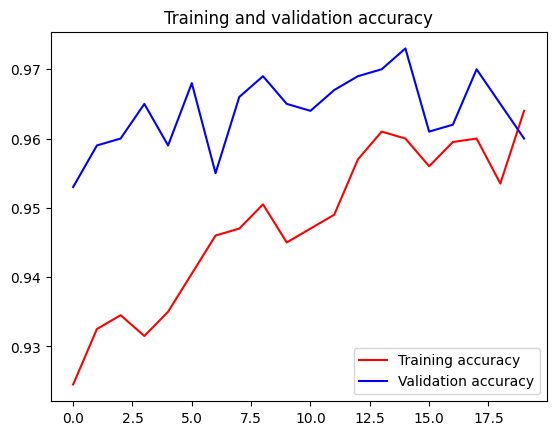

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()